<center>

#*Trabajo Practico 1*
###Introducción al Aprendizaje Profundo
##*- Grupo 15 -*
#### *Joaquín Aguirre, José Mariano García y María Azul Chincarini*

# 1. Introducción

Vamos a trabajar con un dataset correspondiente a los resultados de la encuesta 'Behavioral Risk Factor Surveillance System' (BRFSS), llevada a cabo por la organización ' Centers for Disease Control and Prevention' (CDC) de los Estados Unidos. Se trata de una encuesta telefónica en la que se le pregunta a cientos de miles de estadounidenses sobre sus condiciones de salud, sus comportamientos y otra información de carácter personal, como edad, sexo, educación, etc.

Particularmente, vamos a trabajar con el dataset `diabetes _ binary _ 5050split _ health _ indicators _ BRFSS2015.csv`, que se trata de una versión ya curada de la base original, con 70.692 entradas y 21 variables. Esta versión se caracteriza por el hecho de que la mitad de los encuestados no tiene diabetes (Diabetes_binary = 0), y la otra mitad tiene prediabetes o diabetes (Diabetes_binary = 1).

El objetivo de este trabajo es entrenar redes neuronales que puedan predecir correctamente si un individuo es o no diabético de acuerdo a sus otras característcas.

# 1.1. Carga de paquetes y de la base de datos:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, transforms
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import metrics
from sklearn.metrics import accuracy_score

url = 'https://raw.githubusercontent.com/jaguirre-econ/Proyectos-Ciencia-de-Datos/main/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
df = pd.read_csv(url)

# 2. Inspección del dataset

In [ ]:
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


In [ ]:
df.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [ ]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,...,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,0.563458,0.525703,0.975259,29.856985,0.475273,0.062171,0.147810,0.703036,0.611795,...,0.954960,0.093914,2.837082,3.752037,5.810417,0.252730,0.456997,8.584055,4.920953,5.698311
std,0.500004,0.495960,0.499342,0.155336,7.113954,0.499392,0.241468,0.354914,0.456924,0.487345,...,0.207394,0.291712,1.113565,8.155627,10.062261,0.434581,0.498151,2.852153,1.029081,2.175196
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [ ]:
for column in df.columns:
    unique_values = sorted(df[column].unique().tolist(), reverse = True)
    print(f'Unique values in {column}: {unique_values}')

Unique values in Diabetes_binary: [1.0, 0.0]
Unique values in HighBP: [1.0, 0.0]
Unique values in HighChol: [1.0, 0.0]
Unique values in CholCheck: [1.0, 0.0]
Unique values in BMI: [98.0, 95.0, 92.0, 89.0, 87.0, 86.0, 85.0, 84.0, 83.0, 82.0, 81.0, 80.0, 79.0, 78.0, 77.0, 76.0, 75.0, 74.0, 73.0, 72.0, 71.0, 70.0, 69.0, 68.0, 67.0, 66.0, 65.0, 64.0, 63.0, 62.0, 61.0, 60.0, 59.0, 58.0, 57.0, 56.0, 55.0, 54.0, 53.0, 52.0, 51.0, 50.0, 49.0, 48.0, 47.0, 46.0, 45.0, 44.0, 43.0, 42.0, 41.0, 40.0, 39.0, 38.0, 37.0, 36.0, 35.0, 34.0, 33.0, 32.0, 31.0, 30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, 21.0, 20.0, 19.0, 18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0]
Unique values in Smoker: [1.0, 0.0]
Unique values in Stroke: [1.0, 0.0]
Unique values in HeartDiseaseorAttack: [1.0, 0.0]
Unique values in PhysActivity: [1.0, 0.0]
Unique values in Fruits: [1.0, 0.0]
Unique values in Veggies: [1.0, 0.0]
Unique values in HvyAlcoholConsump: [1.0, 0.0]
Unique values in AnyHealthcare: [1.0, 0.0]
Unique value

Del análisis anterior se desprende que de las 22 variables, 15 son variables binarias o dummy (asumen los valores 0 o 1), y el resto variables numéricas que asumen más de dos valores distintos. El significado de cada variable se menciona a continuación:

- *Variables binarias*:

**Diabetes_binary**: 0 = no diabetes 1 = prediabetes or diabetes

**HighBP**: 0 = no high Blood Pressure 1 = high BP

**HighChol**: 0 = no high cholesterol 1 = high cholesterol

**CholCheck**: 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years

**Smoker**: Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes

**Stroke**: (Ever told) you had a stroke. 0 = no 1 = yes

**HeartDiseaseorAttack**: coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes

**PhysActivity**: physical activity in past 30 days - not including job 0 = no 1 = yes

**Fruits**: Consume Fruit 1 or more times per day 0 = no 1 = yes

**Veggies**: Consume Vegetables 1 or more times per day 0 = no 1 = yes

**HvyAlcoholConsump**: (adult men >=14 drinks per week and adult women>=7 drinks per week) 0 = no 1 = yes

**AnyHealthcare**: Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes

**NoDocbcCost**: Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes

**DiffWalk**: Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes

**Sex**: 0 = female 1 = male

- *Variables numéricas no binarias*:

**BMI**: Body Mass Index

**GenHlth**: Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor

**MentHlth**: days of poor mental health scale 1-30 days

**PhysHlth**: physical illness or injury days in past 30 days scale 1-30

**Age**: 13-level age category. 1 = 18-24 9 = 60-64 13 = 80 or older

**Education**: Education level scale 1-6. 1 = Never attended school or only kindergarten 2 = elementary etc.

**Income**: Income scale scale 1-8. 1 = less than \$10,000 5 = less than \$35,000 8 = \$75,000 or more

Ahora creamos dos subsets del data frame original, uno para las variables binarias y otro para las no binarias. Nos ayudamos de esta división para graficar la distribución de cada variable.

In [ ]:
df_binary = df[['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']]

df_num = df[['BMI','GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education',
       'Income']]

Primero visualizamos la distribución de las variables binarias:

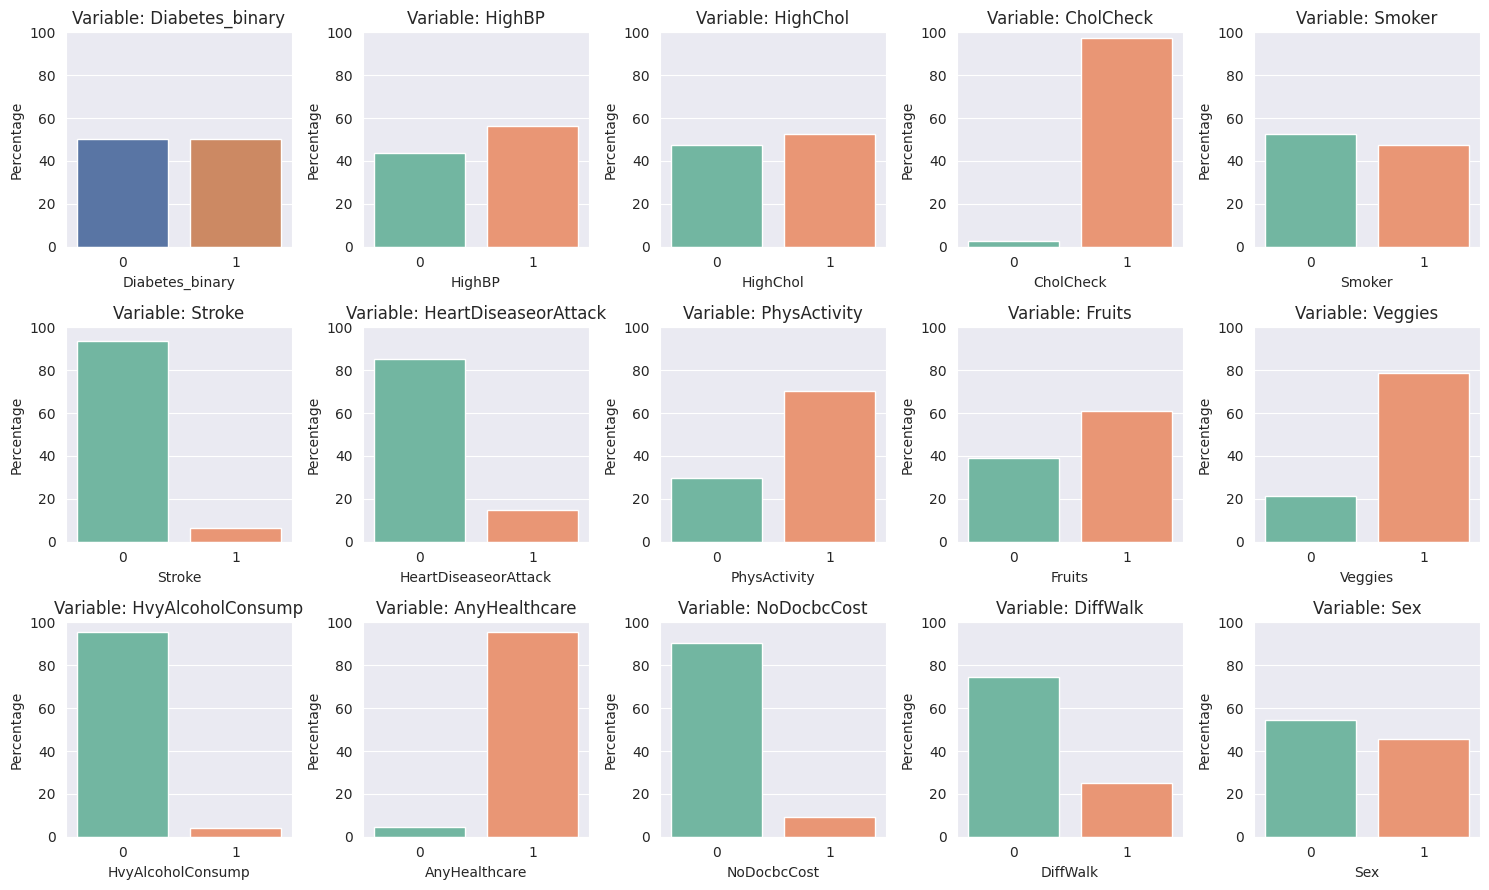

In [ ]:
num_rows = 3
num_cols = 5

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*3, num_rows*3))

axes_flat = axes.flatten()

for idx, column in enumerate(df_binary.columns):
  percentage_values = df_binary[column].value_counts(normalize=True) * 100

  sns.barplot(x=percentage_values.index, y=percentage_values.values, ax=axes_flat[idx])

  axes_flat[idx].set(xlabel=column, ylabel='Percentage')
  axes_flat[idx].set_title(f'Variable: {column}')
  axes_flat[idx].set_ylim(0, 100)

  sns.set_style("darkgrid")
  custom_palette = sns.color_palette("Set2")
  sns.set_palette(custom_palette)

  axes_flat[idx].xaxis.set_major_formatter(StrMethodFormatter('{x:0.0f}'))

for i in range(len(df_binary.columns), len(axes_flat)):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

Diabetes_binary es la única variable en la que las dos categorías se presentan en la misma proporción (50/50). Hay algunas variables cuya distribución es muy despareja, como CholCheck (casi todos los encuestados se chequearon el colesterol en los últimos 5 años), Stroke (muy pocos tuvieron un ACV), HvyAlcoholConsump (casi nadie consume alcohol de forma excesiva) y AnyHealthcare (prácticamente todos los encuestados están cubiertos por algún plan de atención médica).

Ahora hacemos lo mismo, pero para las variables no binarias. Para facilitar la visualización, lo hacemos en 2 partes. Por un lado, aquellas variables que asumen pocos valores (usamos gráficos de barras), y por otro las que asumen muchos valores (usamos histogramas).

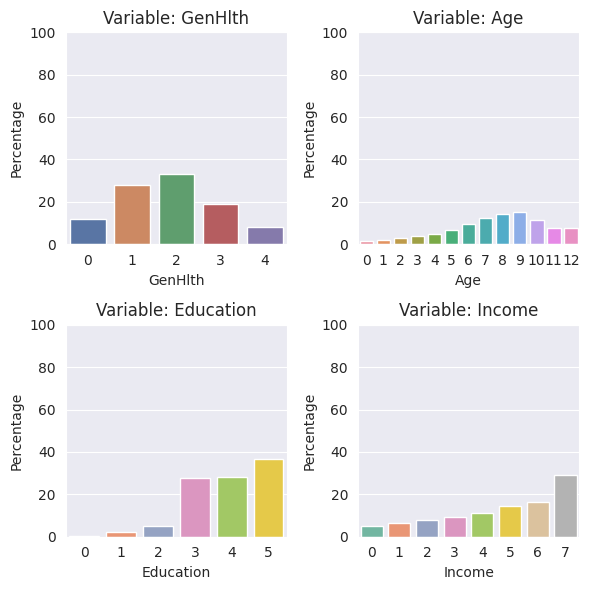

In [ ]:
df_num_1 = df_num[['GenHlth', 'Age', 'Education', 'Income']]

num_rows = 2
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*3, num_rows*3))

axes_flat = axes.flatten()

for idx, column in enumerate(df_num_1.columns):
  percentage_values = df_num_1[column].value_counts(normalize=True) * 100

  sns.barplot(x=percentage_values.index, y=percentage_values.values, ax=axes_flat[idx])

  axes_flat[idx].set(xlabel=column, ylabel='Percentage')
  axes_flat[idx].set_title(f'Variable: {column}')
  axes_flat[idx].set_ylim(0, 100)

  sns.set_style("darkgrid")
  custom_palette = sns.color_palette("Set2")
  sns.set_palette(custom_palette)

  axes_flat[idx].xaxis.set_major_formatter(StrMethodFormatter('{x:0.0f}'))

for i in range(len(df_num_1.columns), len(axes_flat)):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

De estos gráficos se desprende que la mayoría de los encuestados considera que su estado de salud es, en términos generales, muy bueno o bueno. Por otra parte, se concluye que el grupo de encuestados está formado más que nada por personas de mediana edad, de nivel educativo medio o alto, y de ingresos menores a \$75.000 dólares anuales.

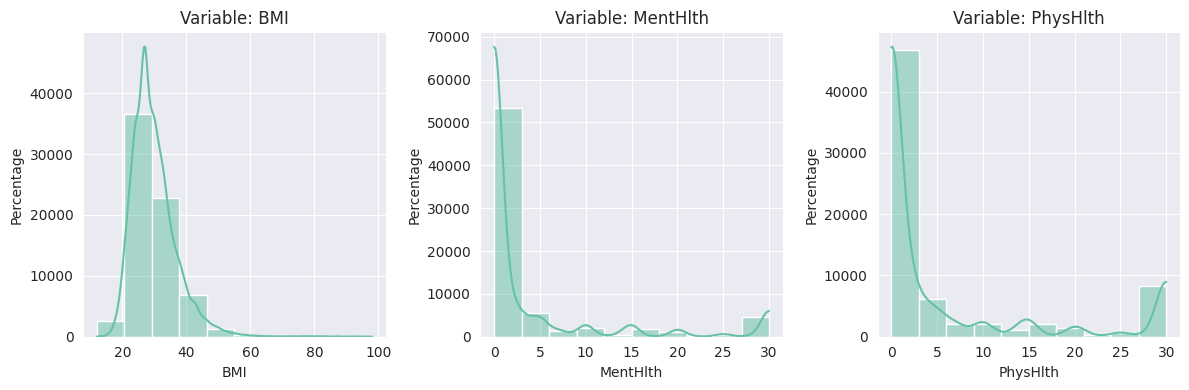

In [ ]:
df_num_2 = df_num[['BMI','MentHlth', 'PhysHlth']]

num_rows = 1
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*4, num_rows*4))

axes_flat = axes.flatten()

for idx, column in enumerate(df_num_2.columns):
    # Plot histogram for the current variable
  sns.histplot(df_num_2[column], ax=axes_flat[idx], kde=True, bins=10)
  axes_flat[idx].set(xlabel=column, ylabel='Percentage')
  axes_flat[idx].set_title(f'Variable: {column}')

  sns.set_style("darkgrid")
  custom_palette = sns.color_palette("deep")
  sns.set_palette(custom_palette)

  axes_flat[idx].xaxis.set_major_formatter(StrMethodFormatter('{x:0.0f}'))

for i in range(len(df_num_2.columns), len(axes_flat)):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

De estos histogramas se puede decir que la gran mayoría de los encuestados no registró días de dolencias físicas ni de mala salud mental, y posee en peso saludable (BMI entre 18.5 y 25) o tiene sobrepeso (BMI entre 25 y 30). La cantidad de personas con sobrepeso es significativa. Por ende, para terminar con la inspección del dataset, analizamos en detalle cómo se distribuyen los encuestados según su BMI:

In [ ]:
underweight = ((df['BMI'] < 18.5).sum() / len(df)) * 100
healthy = (df['BMI'].between(18.5, 24.99).sum() / len(df)) * 100
overweight = (df['BMI'].between(25, 29.99).sum() / len(df)) * 100
obese = ((df['BMI'] >= 30).sum() / len(df)) * 100

print(f"Porcentaje de encuestados con peso por debajo del saludable: {underweight:.1f}%")
print(f"Porcentaje de encuestados con peso saludable: {healthy:.1f}%")
print(f"Porcentaje de encuestados con peso por encima del saludable: {overweight:.1f}%")
print(f"Porcentaje de encuestados obesos: {obese:.1f}%")

Porcentaje de encuestados con peso por debajo del saludable: 0.9%
Porcentaje de encuestados con peso saludable: 20.5%
Porcentaje de encuestados con peso por encima del saludable: 34.1%
Porcentaje de encuestados obesos: 44.5%


Si bien no significa que sean exactamente las mismas personas, se destaca que el porcentaje de obsesos es del 44,5%, casi la mitad, tal como es el caso de las personas con diabetes.

# 3. Aplicación de redes neuronales

## 3.1. Red Neuronal por defecto (baseline)

Comenzamos por un modelo de redes neuronales para predecir la presencia o no de diabetes (o prediabetes) por defecto, usando todas las variables y sin escalarlas.

In [ ]:
# Separar X e y
X = df.drop('Diabetes_binary',axis=1).values
y = df['Diabetes_binary'].values
X,y

(array([[ 1.,  0.,  1., ...,  4.,  6.,  8.],
        [ 1.,  1.,  1., ..., 12.,  6.,  8.],
        [ 0.,  0.,  1., ..., 13.,  6.,  8.],
        ...,
        [ 1.,  1.,  1., ..., 13.,  6.,  4.],
        [ 1.,  1.,  1., ..., 11.,  2.,  4.],
        [ 1.,  1.,  1., ...,  9.,  6.,  2.]]),
 array([0., 0., 0., ..., 1., 1., 1.]))

In [ ]:
# Dividimos el conjunto de datos en conjuntos de entrenamiento, validación y test
seed = 32
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

# Convertir los datos en tensores de PyTorch
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

Definición del modelo:

In [ ]:
class baseline(nn.Module):
    def __init__(self,
                 input_features = X.shape[1], # Cantidad de features de entrada
                 hidden_layer_1 = 5, # Cantidad de neuronas de la primera capa oculta
                 hidden_layer_2 = 5, # Cantidad de neuronas de la segunda capa oculta
                 output_features = 2 # Dado que Diabetes_binary es binaria, 0 o 1
                 ):
        super().__init__() # Llama al método __init__ de la clase nn.Module
        # Generamos una red con 3 capas lineales (la última es de salida)
        self.fully_connected_1 = nn.Linear(input_features, hidden_layer_1)
        self.fully_connected_2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.output = nn.Linear(hidden_layer_2, output_features)

    # Foward pass
    def forward(self, x):
      x = F.relu(self.fully_connected_1(x))
      x = F.relu(self.fully_connected_2(x))
      x = self.output(x)
      return x

Instanciamos el modelo:

In [ ]:
model = baseline()
criterion = nn.CrossEntropyLoss() # Función de loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Definimos el optimizador, y un learning rate de 0,1
model.parameters

<bound method Module.parameters of baseline(
  (fully_connected_1): Linear(in_features=21, out_features=5, bias=True)
  (fully_connected_2): Linear(in_features=5, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=2, bias=True)
)>

In [ ]:
y_pred = model.forward(X_train)
y_pred

tensor([[ 0.0485, -0.2686],
        [ 0.0871, -0.2419],
        [ 0.0959, -0.2332],
        ...,
        [ 0.0314, -0.2814],
        [ 0.0538, -0.2647],
        [ 0.0329, -0.2803]], grad_fn=<AddmmBackward0>)

In [ ]:
epochs = 101

train_losses = []
val_losses = []

for epoch in tqdm.trange(epochs):
  epoch += 1

  # Foward pass y obtener la prediccion
  y_pred = model.forward(X_train)

  # Calcular la loss de cada epoca
  loss_train = criterion(y_pred, y_train)
  train_losses.append(loss_train.item())

  if epoch%10 == 1:
    print(f'epoch: {epoch:2}  loss: {loss_train.item():10.4f}')

  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step() #Actualiza todos los parametros del modelo (pesos y biases)

  with torch.no_grad():
    y_pred_val = model.forward(X_val)
    # Calcular la loss de cada epoca
    loss_val = criterion(y_pred_val, y_val)
    val_losses.append(loss_val.item())

  6%|▌         | 6/101 [00:00<00:01, 51.54it/s]

epoch:  1  loss:     0.7076
epoch: 11  loss:     0.6952


 30%|██▉       | 30/101 [00:00<00:01, 50.43it/s]

epoch: 21  loss:     0.6935
epoch: 31  loss:     0.6934

 36%|███▌      | 36/101 [00:00<00:01, 50.76it/s]


epoch: 41  loss:     0.6932


 59%|█████▉    | 60/101 [00:01<00:00, 51.52it/s]

epoch: 51  loss:     0.6932
epoch: 61  loss:     0.6931


 77%|███████▋  | 78/101 [00:01<00:00, 50.71it/s]

epoch: 71  loss:     0.6932
epoch: 81  loss:     0.6931


 95%|█████████▌| 96/101 [00:01<00:00, 50.24it/s]

epoch: 91  loss:     0.6931
epoch: 101  loss:     0.6931


100%|██████████| 101/101 [00:02<00:00, 50.40it/s]


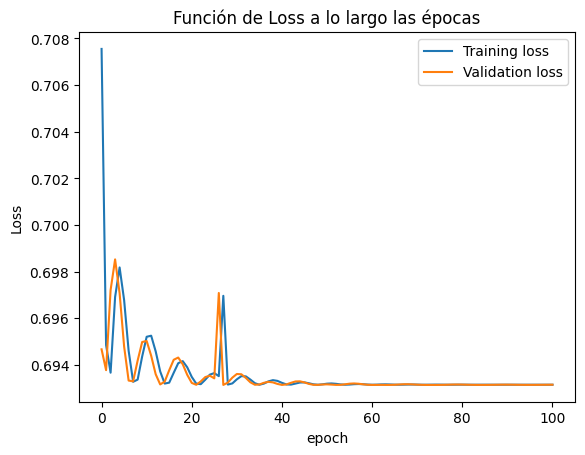

In [ ]:
plt.title('Función de Loss a lo largo las épocas')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
  y_pred_test = model.forward(X_test)
  loss_test = criterion(y_pred_test, y_test)
  print(f'Loss en el conjunto de prueba: {loss_test:.8f}')

  predictions_test = torch.argmax(y_pred_test, dim=1)
  correct_predictions_test = (predictions_test == y_test).sum().item()
  total_samples_test = y_test.size(0)
  accuracy_test = (correct_predictions_test / total_samples_test) * 100
  print(f'Accuracy en el conjunto de prueba: {accuracy_test:.2f}%')

  # Calcular el recall
  true_positives_test = ((predictions_test == 1) & (y_test == 1)).sum().item()
  actual_positives_test = (y_test == 1).sum().item()
  recall_test = (true_positives_test / actual_positives_test)*100
  print(f'Recall en el conjunto de prueba: {recall_test:.2f}%')



# Evaluación en el conjunto de validación
with torch.no_grad():
  y_pred_val = model.forward(X_val)
  loss_val = criterion(y_pred_val, y_val)
  print(f'Loss en el conjunto de validación: {loss_val:.8f}')

  predictions_val = torch.argmax(y_pred_val, dim=1)
  correct_predictions_val = (predictions_val == y_val).sum().item()
  total_samples_val = y_val.size(0)
  accuracy_val = (correct_predictions_val / total_samples_val) * 100
  print(f'Accuracy en el conjunto de validación: {accuracy_val:.2f}%')

  # Calcular el recall
  true_positives_val = ((predictions_val == 1) & (y_val == 1)).sum().item()
  actual_positives_val = (y_val == 1).sum().item()
  recall_val = (true_positives_val / actual_positives_val)*100
  print(f'Recall en el conjunto de validación: {recall_val:.2f}%')




Loss en el conjunto de prueba: 0.69314629
Accuracy en el conjunto de prueba: 50.37%
Recall en el conjunto de prueba: 100.00%
Loss en el conjunto de validación: 0.69314790
Accuracy en el conjunto de validación: 49.79%
Recall en el conjunto de validación: 100.00%


- **Problemas encontrados**:
Al momento de correr el modelo observamos que no se logra una minimizacion adecuada de la funcion de loss, por lo que el modelo no parece mejorar con cada iteracion. Nuestra hipotesis es que la funcion de perdida quiza no es adecuada para este problema y genera minimos locales donde el gradiente se anula.


## Red neuronal con datos escalados

Primero escalamos las variables numéricas no binarias, y dejamos las binarias como están:

In [ ]:
# Código que escala sólo la variables numéricas no binarias

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_num_scaled = scaler.fit_transform(df_num)
df_num_scaled

df_num_scaled = pd.DataFrame(df_num_scaled, columns=['BMI','GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education',
       'Income'])
df_num_scaled = df_num_scaled.reset_index()
df_num_scaled = df_num_scaled.drop(columns='index')
df_num_scaled

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
0,0.162791,0.50,0.166667,1.000000,0.250000,1.0,1.000000
1,0.162791,0.50,0.000000,0.000000,0.916667,1.0,1.000000
2,0.162791,0.00,0.000000,0.333333,1.000000,1.0,1.000000
3,0.186047,0.50,0.000000,0.100000,0.833333,1.0,1.000000
4,0.197674,0.25,0.000000,0.000000,0.583333,0.8,1.000000
...,...,...,...,...,...,...,...
70687,0.290698,0.75,0.000000,0.000000,0.416667,0.6,0.000000
70688,0.197674,0.25,0.000000,0.000000,0.750000,0.4,0.714286
70689,0.151163,1.00,0.500000,0.000000,1.000000,1.0,0.428571
70690,0.069767,0.75,0.000000,0.000000,0.833333,0.2,0.428571


In [ ]:
# Unimos las no binarias escaladas con las binarias

df_rejoined = pd.concat([df_binary,df_num_scaled], axis=1)
df = df_rejoined
df

,Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,DiffWalk,Sex,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.162791,0.50,0.166667,1.000000,0.250000,1.0,1.000000
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.162791,0.50,0.000000,0.000000,0.916667,1.0,1.000000
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.162791,0.00,0.000000,0.333333,1.000000,1.0,1.000000
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.186047,0.50,0.000000,0.100000,0.833333,1.0,1.000000
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.197674,0.25,0.000000,0.000000,0.583333,0.8,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.290698,0.75,0.000000,0.000000,0.416667,0.6,0.000000
70688,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.197674,0.25,0.000000,0.000000,0.750000,0.4,0.714286
70689,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.151163,1.00,0.500000,0.000000,1.000000,1.0,0.428571
70690,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.069767,0.75,0.000000,0.000000,0.833333,0.2,0.428571


Ahora nos fijamos si con esta modificación logramos mejorar la red neuronal anterior:

In [ ]:
X = df.drop('Diabetes_binary',axis=1).values
y = df['Diabetes_binary'].values

seed = 33
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

model = baseline()

criterion = nn.CrossEntropyLoss() # Función de loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Definimos el optimizador, y un learning rate de 0,1

epochs = 101

train_losses = []
val_losses = []

for epoch in tqdm.trange(epochs):
  epoch+=1

  # Foward pass y obtener la prediccion
  y_pred = model.forward(X_train)

  # Calcular la loss de cada epoca
  loss_train = criterion(y_pred, y_train)
  train_losses.append(loss_train.item())

  if epoch%10 == 1:
    print(f'epoch: {epoch:2}  loss: {loss_train.item():10.4f}')

  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step() #Actualiza todos los parametros del modelo (pesos y biases)

  with torch.no_grad():
    y_pred_val = model.forward(X_val)

    # Calcular la loss de cada epoca
    loss_val = criterion(y_pred_val, y_val)
    val_losses.append(loss_val.item())

  5%|▍         | 5/101 [00:00<00:02, 42.67it/s]

epoch:  1  loss:     0.6963


 15%|█▍        | 15/101 [00:00<00:02, 40.77it/s]

epoch: 11  loss:     0.5548


 25%|██▍       | 25/101 [00:00<00:01, 40.41it/s]

epoch: 21  loss:     0.5459


 35%|███▍      | 35/101 [00:00<00:01, 41.13it/s]

epoch: 31  loss:     0.5356


 47%|████▋     | 47/101 [00:01<00:01, 46.75it/s]

epoch: 41  loss:     0.5262
epoch: 51  loss:     0.5202


 68%|██████▊   | 69/101 [00:01<00:00, 49.66it/s]

epoch: 61  loss:     0.5163
epoch: 71  loss:     0.5132


 85%|████████▌ | 86/101 [00:01<00:00, 50.29it/s]

epoch: 81  loss:     0.5108
epoch: 91  loss:     0.5093


100%|██████████| 101/101 [00:02<00:00, 46.61it/s]

epoch: 101  loss:     0.5128


In [ ]:
with torch.no_grad():
  y_pred_test = model.forward(X_test)
  loss_test = criterion(y_pred_test, y_test)
  print(f'Loss en el conjunto de prueba: {loss_test:.8f}')

  predictions_test = torch.argmax(y_pred_test, dim=1)
  correct_predictions_test = (predictions_test == y_test).sum().item()
  total_samples_test = y_test.size(0)
  accuracy_test = correct_predictions_test / total_samples_test * 100
  print(f'Accuracy en el conjunto de prueba: {accuracy_test:.2f}%')

  # Calcular el recall
  true_positives_test = ((predictions_test == 1) & (y_test == 1)).sum().item()
  actual_positives_test = (y_test == 1).sum().item()
  recall_test = (true_positives_test / actual_positives_test)*100
  print(f'Recall en el conjunto de prueba: {recall_test:.2f}%')

with torch.no_grad():
  y_pred = model.forward(X_val)
  loss = criterion(y_pred, y_val)
  print(f'Loss en el conjunto de validación: {loss:.8f}')

with torch.no_grad():
  y_pred_val = model.forward(X_val)
  loss_val = criterion(y_pred_val, y_val)
  val_losses.append(loss_val.item())

  predictions = torch.argmax(y_pred_val, dim=1)
  correct_predictions = (predictions == y_val).sum().item()
  total_samples = y_val.size(0)
  accuracy = correct_predictions / total_samples * 100
  print(f'Accuracy en el conjunto de validación: {accuracy:.2f}%')

  # Calcular el recall
  true_positives_val = ((predictions == 1) & (y_val == 1)).sum().item()
  actual_positives_val = (y_val == 1).sum().item()
  recall_val = (true_positives_val / actual_positives_val)*100
  print(f'Recall en el conjunto de validación: {recall_val:.2f}%')


Loss en el conjunto de prueba: 0.50591171
Accuracy en el conjunto de prueba: 74.88%
Recall en el conjunto de prueba: 79.69%
Loss en el conjunto de validación: 0.50856197
Accuracy en el conjunto de validación: 75.25%
Recall en el conjunto de validación: 80.00%


Aqui observamos una mejora de las metricas, la normalizacion de datos ayudo con el estancamiento del algoritmo de optimizacion, y se logro reducir la funcion loss.

# Modelo 2


En la próxima red neuronal, eliminamos una capa y disminuimos el número de neuronas. Además usamos la función sigmoide dado que planteamos una red de arquitectura más simple (menos capas) y porque la clasificación es binaria.  

In [ ]:
class Modelo_2(nn.Module):
    def __init__(self,
                 input_features = X_train.shape[1], # Cantidad de features de entrada
                 hidden_layer_1 = 4, # Cantidad de neuronas de la primera capa oculta
                 output_features = 2
                 ):
        super().__init__() # Llama al método __init__ de la clase nn.Module
        self.fully_connected_1 = nn.Linear(input_features, hidden_layer_1)
        self.output = nn.Linear(hidden_layer_1, output_features)

    # Foward pass
    def forward(self, x):
      x = F.sigmoid(self.fully_connected_1(x))
      x = self.output(x)
      return x

In [ ]:
model = Modelo_2()
criterion = nn.CrossEntropyLoss() # Función de loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Definimos el optimizador, y un learning rate de 0,1
model.parameters


<bound method Module.parameters of Modelo_2(
  (fully_connected_1): Linear(in_features=21, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=2, bias=True)
)>

In [ ]:
epochs = 101

train_losses = []
val_losses = []

for epoch in tqdm.trange(epochs):
  epoch += 1

  # Foward pass y obtener la prediccion
  y_pred = model.forward(X_train)

  # Asegurarse de que las dimensiones de y_pred_val sean adecuadas
  y_pred_val = y_pred_val.squeeze()  # Eliminar dimensión adicional
  y_pred_val = y_pred_val.squeeze()  # Eliminar dimensión adicional


  # Calcular la loss de cada epoca
  loss_train = criterion(y_pred, y_train)
  train_losses.append(loss_train.item())

  if epoch%10 == 1:
    print(f'epoch: {epoch:2}  loss: {loss_train.item():10.4f}')


  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step() #Actualiza todos los parametros del modelo (pesos y biases)

  with torch.no_grad():
    y_pred_val = model.forward(X_val)

      # Calcular la loss de cada epoca
    loss_val = criterion(y_pred_val, y_val)
    val_losses.append(loss_val.item())

  6%|▌         | 6/101 [00:00<00:01, 54.31it/s]

epoch:  1  loss:     0.9577
epoch: 11  loss:     0.6700


 31%|███       | 31/101 [00:00<00:01, 57.36it/s]

epoch: 21  loss:     0.6295
epoch: 31  loss:     0.5829


 49%|████▊     | 49/101 [00:00<00:00, 58.08it/s]

epoch: 41  loss:     0.5607
epoch: 51  loss:     0.5512


 66%|██████▋   | 67/101 [00:01<00:00, 57.41it/s]

epoch: 61  loss:     0.5425
epoch: 71  loss:     0.5346


 86%|████████▌ | 87/101 [00:01<00:00, 60.37it/s]

epoch: 81  loss:     0.5301
epoch: 91  loss:     0.5254


100%|██████████| 101/101 [00:01<00:00, 58.22it/s]

epoch: 101  loss:     0.5214


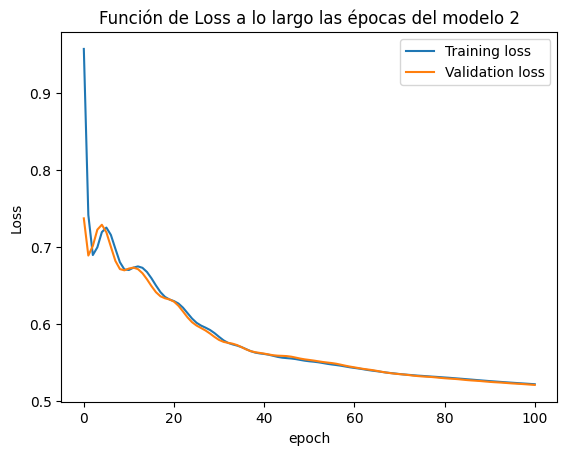

In [ ]:
plt.title('Función de Loss a lo largo las épocas del modelo 2')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
  y_pred_test = model.forward(X_test)
  loss_test = criterion(y_pred_test, y_test)
  print(f'Loss en el conjunto de prueba: {loss_test:.8f}')

  predictions_test = torch.argmax(y_pred_test, dim=1)
  correct_predictions_test = (predictions_test == y_test).sum().item()
  total_samples_test = y_test.size(0)
  accuracy_test = (correct_predictions_test / total_samples_test) * 100
  print(f'Accuracy en el conjunto de prueba: {accuracy_test:.2f}%')

  # Calcular el recall
  true_positives_test = ((predictions_test == 1) & (y_test == 1)).sum().item()
  actual_positives_test = (y_test == 1).sum().item()
  recall_test = (true_positives_test / actual_positives_test)*100
  print(f'Recall en el conjunto de prueba: {recall_test:.2f}%')



# Evaluación en el conjunto de validación
with torch.no_grad():
  y_pred_val = model.forward(X_val)
  loss_val = criterion(y_pred_val, y_val)
  print(f'Loss en el conjunto de validación: {loss_val:.8f}')

  predictions_val = torch.argmax(y_pred_val, dim=1)
  correct_predictions_val = (predictions_val == y_val).sum().item()
  total_samples_val = y_val.size(0)
  accuracy_val = (correct_predictions_val / total_samples_val) * 100
  print(f'Accuracy en el conjunto de validación: {accuracy_val:.2f}%')

  # Calcular el recall
  true_positives_val = ((predictions_val == 1) & (y_val == 1)).sum().item()
  actual_positives_val = (y_val == 1).sum().item()
  recall_val = (true_positives_val / actual_positives_val)*100
  print(f'Recall en el conjunto de validación: {recall_val:.2f}%')



Loss en el conjunto de prueba: 0.51882559
Accuracy en el conjunto de prueba: 74.60%
Recall en el conjunto de prueba: 80.27%
Loss en el conjunto de validación: 0.52043402
Accuracy en el conjunto de validación: 74.58%
Recall en el conjunto de validación: 80.45%


Modelo 3

  5%|▍         | 5/101 [00:00<00:02, 42.46it/s]

epoch:  1  loss:     0.7531


 15%|█▍        | 15/101 [00:00<00:02, 42.02it/s]

epoch: 11  loss:     0.6961


 25%|██▍       | 25/101 [00:00<00:01, 40.94it/s]

epoch: 21  loss:     0.6952


 35%|███▍      | 35/101 [00:00<00:01, 41.16it/s]

epoch: 31  loss:     0.6795


 45%|████▍     | 45/101 [00:01<00:01, 40.61it/s]

epoch: 41  loss:     0.5982


 54%|█████▍    | 55/101 [00:01<00:01, 41.15it/s]

epoch: 51  loss:     0.5578


 64%|██████▍   | 65/101 [00:01<00:00, 41.07it/s]

epoch: 61  loss:     0.5310


 74%|███████▍  | 75/101 [00:01<00:00, 40.82it/s]

epoch: 71  loss:     0.5247


 84%|████████▍ | 85/101 [00:02<00:00, 40.93it/s]

epoch: 81  loss:     0.5219


 94%|█████████▍| 95/101 [00:02<00:00, 40.83it/s]

epoch: 91  loss:     0.5165


100%|██████████| 101/101 [00:02<00:00, 40.97it/s]


epoch: 101  loss:     0.5129


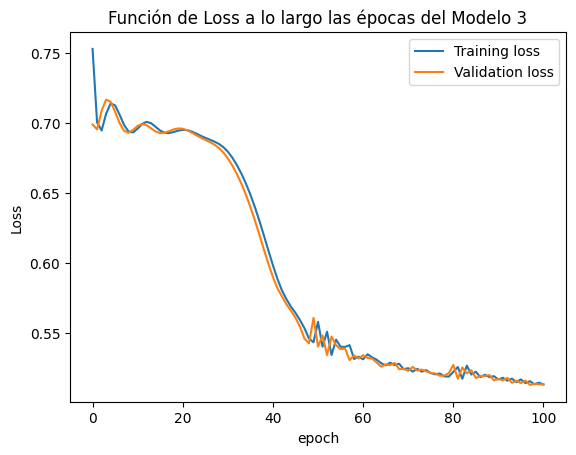

Loss en el conjunto de prueba: 0.51155448
Accuracy en el conjunto de prueba: 74.33%
Recall en el conjunto de prueba: 84.76%
Loss en el conjunto de validación: 0.51305068
Accuracy en el conjunto de validación: 74.67%
Recall en el conjunto de validación: 85.32%


In [ ]:
class Modelo_3(nn.Module):
    def __init__(self,
                 input_features = X_train.shape[1], # Cantidad de features de entrada
                 hidden_layer_1 = 6,
                 hidden_layer_2 = 4,
                 hidden_layer_3 = 3,
                 hidden_layer_4 = 2,
                 output_features = 2
                 ):
        super().__init__()
        self.fully_connected_1 = nn.Linear(input_features, hidden_layer_1)
        self.fully_connected_2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.fully_connected_3 = nn.Linear(hidden_layer_2, hidden_layer_3)
        self.fully_connected_4 = nn.Linear(hidden_layer_3, hidden_layer_4)
        self.output = nn.Linear(hidden_layer_4, output_features)

    # Foward pass
    def forward(self, x):
      x = F.sigmoid(self.fully_connected_1(x))
      x = F.sigmoid(self.fully_connected_2(x))
      x = F.sigmoid(self.fully_connected_3(x))
      x = F.sigmoid(self.fully_connected_4(x))
      x = self.output(x)
      return x

model = Modelo_3()
criterion = nn.CrossEntropyLoss() # Función de loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Definimos el optimizador, y un learning rate de 0,1
model.parameters


epochs = 101

train_losses = []
val_losses = []

for epoch in tqdm.trange(epochs):
  epoch += 1

  # Foward pass y obtener la prediccion
  y_pred = model.forward(X_train)

  # Calcular la loss de cada epoca
  loss_train = criterion(y_pred, y_train)
  train_losses.append(loss_train.item())

  if epoch%10 == 1:
    print(f'epoch: {epoch:2}  loss: {loss_train.item():10.4f}')

  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step() #Actualiza todos los parametros del modelo (pesos y biases)

  with torch.no_grad():
    y_pred_val = model.forward(X_val)

      # Calcular la loss de cada epoca
    loss_val = criterion(y_pred_val, y_val)
    val_losses.append(loss_val.item())


plt.title('Función de Loss a lo largo las épocas del Modelo 3')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

with torch.no_grad():
  y_pred_test = model.forward(X_test)
  loss_test = criterion(y_pred_test, y_test)
  print(f'Loss en el conjunto de prueba: {loss_test:.8f}')

  predictions_test = torch.argmax(y_pred_test, dim=1)
  correct_predictions_test = (predictions_test == y_test).sum().item()
  total_samples_test = y_test.size(0)
  accuracy_test = (correct_predictions_test / total_samples_test) * 100
  print(f'Accuracy en el conjunto de prueba: {accuracy_test:.2f}%')

  # Calcular el recall
  true_positives_test = ((predictions_test == 1) & (y_test == 1)).sum().item()
  actual_positives_test = (y_test == 1).sum().item()
  recall_test = (true_positives_test / actual_positives_test)*100
  print(f'Recall en el conjunto de prueba: {recall_test:.2f}%')



# Evaluación en el conjunto de validación
with torch.no_grad():
  y_pred_val = model.forward(X_val)
  loss_val = criterion(y_pred_val, y_val)
  print(f'Loss en el conjunto de validación: {loss_val:.8f}')

  predictions_val = torch.argmax(y_pred_val, dim=1)
  correct_predictions_val = (predictions_val == y_val).sum().item()
  total_samples_val = y_val.size(0)
  accuracy_val = (correct_predictions_val / total_samples_val) * 100
  print(f'Accuracy en el conjunto de validación: {accuracy_val:.2f}%')

  # Calcular el recall
  true_positives_val = ((predictions_val == 1) & (y_val == 1)).sum().item()
  actual_positives_val = (y_val == 1).sum().item()
  recall_val = (true_positives_val / actual_positives_val)*100
  print(f'Recall en el conjunto de validación: {recall_val:.2f}%')



# Conclusión:
En el primer modelo notamos que enfretabamos un problema de desvanecimiento del gradiente, en un intento de sortear este problema probamos con normalizar los datos, lo cual nos dio grandes resultados. Decidimos seguir usando los mismos y probamos dos arquitecturas diferentes, una con menos capas y neuronas, y por otro lado una red mas compleja con 4 capas ocultas y mas cantidad de neuronas.

Notamos que el modelo es sensible a la cantidad de neuronas de la primer capa oculta, una cantidad alta en este parametro puede hacer que el modelo rapidamente pierda la capacidad de converger a valores de loss bajos.

Las metricas obtenidas dejaron en evidencia que dada la naturaleza de nuestro problema la arquitectura simple presento una mejor performance.

Adicionalmente presentamos un grid search en el bloque siguiente, buscando una optimizacion de hiperparametros.

# Optimización de hiperparámetros


In [ ]:
# Definimos la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definimos la grilla de valores de los hiperparámetros
param_grid = {
    'hidden_size1': [16, 32, 64, 128],
    'hidden_size2': [8, 16, 32, 64],
    'lr': [0.001, 0.01, 0.1]
}

best_accuracy = 0.0
best_model = None
best_params = None

# Iteramos sobre la grilla
for params in ParameterGrid(param_grid):
  print(f"\nTraining with hyperparameters: {params}")

  input_size = X_train.shape[1]
  output_size = 2  # Clasificación binaria

  model = NeuralNetwork(input_size, params['hidden_size1'], params['hidden_size2'], output_size)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=params['lr'])

  num_epochs = 63 # seguimos la regla de 3 veces el número de columnas del data frame (21)

  for epoch in range(num_epochs):
      model.train()
      for inputs, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

      # Validación
      model.eval()
      with torch.no_grad():
          correct = 0
          total = 0
          for inputs, labels in val_loader:
              outputs = model(inputs)
              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          accuracy = correct / total
          #print(f'Epoch [{epoch + 1}/{num_epochs}], Accuracy: {accuracy:.4f}')

  if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model
      best_params = params

print("\nBest Model Information:")
print(f"Best Hyperparameters: {best_params}")
print(f"Validation Accuracy of Best Model: {best_accuracy:.4f}")

# Usamos el mejor modelo para testing
best_model.eval()
with torch.no_grad():
  test_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in test_loader:
    outputs = best_model(inputs)
    loss = criterion(outputs, labels)
    test_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  test_accuracy = correct / total
  print(f'Test Loss of Best Model: {test_loss / len(test_loader):.4f}')
  print(f'Test Accuracy of Best Model: {test_accuracy:.4f}')

Best Model Information:

- Best Hyperparameters: {'hidden_size1': 64, 'hidden_size2': 8, 'lr': 0.001}

- Validation Accuracy of Best Model: 0.7549

- Test Loss of Best Model: 0.5041

- Test Accuracy of Best Model: 0.7506

Probando sucesivos valores para hiperparámetros como el learning rate y el número de neuronas en cada capa oculta, el modelo con mejor performance en el conmunto de validación fue un compuesto por 64 neuronas en la capa oculta 1, 8 neuronas en la capa oculta 2 y un learning rate de 0,001. Con esta especificación se alcanzó una accuracy de 75,49% en el conjunto de validación (contra 74,7% con los hiperparámetros sin optimizar) y 75,06% en el conjunto de (contra 74,7% con los hiperparámetros sin optimizar).

# Anexo

In [ ]:
# Código para matriz de correción como heatmap

correlation_matrix = df.corr().round(2)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

No hay ninguna relación de correlación demasiado fuerte. El valor más alto se da en el cruce entre PhysHlth y GenHlth, de 0,55.